In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
plt.style.use('dark_background')
from data_load_preprocess import data

import torch
from torch.autograd import Variable
from viz import viz

%load_ext autoreload
%autoreload 2

# load results from a directory

In [2]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk'
print(os.listdir(out_dir_main))
folder = 'sweep_init_small_centered' # sweep_init_small_centered

['sweep_init_d=1_concentrated', 'data', 'sweep_init_d=6_centered_long', 'models_saved', 'sweep_init_small_centered', 'sweep_init_d=10_concentrated', 'sweep_init_small', 'sweep_init_large']


In [3]:
out_dir = oj(out_dir_main, folder)
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.infer_objects()
results.describe()

,N,batch_size,d_in,d_out,gamma_optimizer,hidden1,lr,max_acc,min_loss,num_iters,num_layers,seed,step_size_optimizer,t_min_loss_plus_10_perc,t_min_loss_plus_20_perc,t_min_loss_plus_5_perc
count,958.0,958.0,958.000000,958.0,958.0,958.00000,9.580000e+02,958.000000,958.000000,958.0,958.0,958.000000,958.0,958.000000,958.000000,958.000000
mean,1000.0,1000.0,1.002088,2.0,0.5,25.18476,1.000000e-03,92.039562,93.203206,2000.0,2.0,29.555324,500.0,1084.029228,878.053236,1260.756785
std,0.0,0.0,0.064617,0.0,0.0,32.60133,6.508611e-19,14.065555,166.358843,0.0,0.0,17.302659,0.0,607.346474,494.027565,705.066410
min,1000.0,1000.0,1.000000,2.0,0.5,1.00000,1.000000e-03,64.100000,0.099092,2000.0,2.0,0.000000,500.0,0.000000,0.000000,0.000000
25%,1000.0,1000.0,1.000000,2.0,0.5,3.00000,1.000000e-03,100.000000,0.236433,2000.0,2.0,15.000000,500.0,1365.250000,1051.250000,1594.250000
50%,1000.0,1000.0,1.000000,2.0,0.5,10.00000,1.000000e-03,100.000000,0.294816,2000.0,2.0,30.000000,500.0,1420.000000,1145.000000,1653.000000
75%,1000.0,1000.0,1.000000,2.0,0.5,45.00000,1.000000e-03,100.000000,0.613966,2000.0,2.0,44.750000,500.0,1434.000000,1169.750000,1668.000000
max,1000.0,1000.0,3.000000,2.0,0.5,100.00000,1.000000e-03,100.000000,553.709534,2000.0,2.0,59.000000,500.0,1985.000000,1973.000000,1992.000000


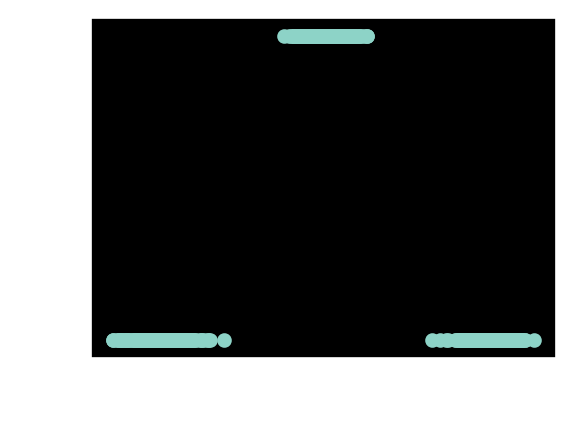

In [8]:
# plot data (only 1d)
X, y_onehot, y_scalar = data.generate_gaussian_data(results.N[0], means=results.means[0], sds=results.sds[0], labs=results.labs[0])
plt.figure(figsize=(4, 3), dpi=150)
viz.plot_data(X, y_scalar)

# compare losses by hidden layer dim

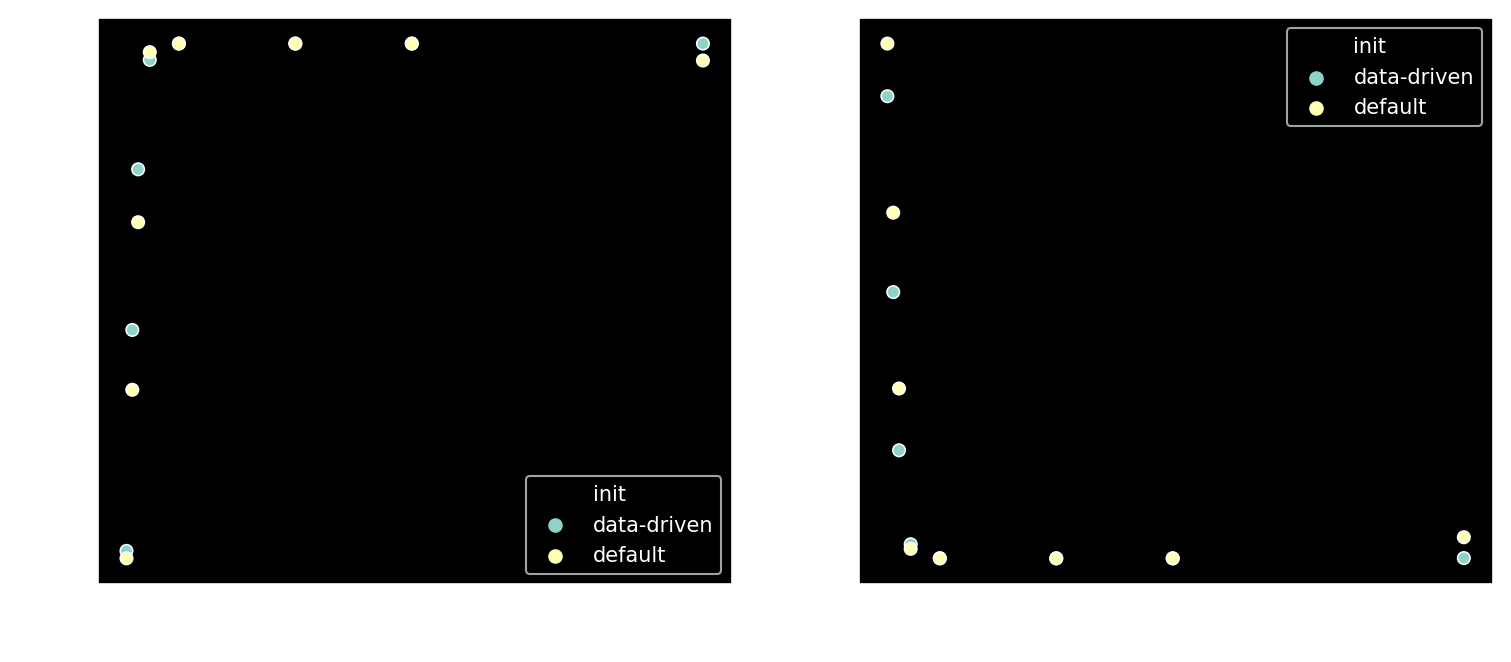

In [4]:
max_accs_default = results[results['init']=='default'].groupby(['hidden1']).mean().reset_index()
max_accs_data = results[results['init']=='data-driven'].groupby(['hidden1']).mean().reset_index()
max_accs_data['init'] = 'data-driven'
max_accs_default['init'] = 'default'
max_accs = pd.concat([max_accs_data, max_accs_default]) # todo: there's probably a nicer way to do this in pd


fig, ax = plt.subplots(figsize=(12, 5), dpi=150, ncols=2, nrows=1)
sns.scatterplot(x='hidden1', y='max_acc', data=max_accs, ax=ax[0], hue="init")

sns.scatterplot(x='hidden1', y='min_loss', data=max_accs, ax=ax[1], hue="init")
plt.show()

# kink analysis

track the relus for a specific run

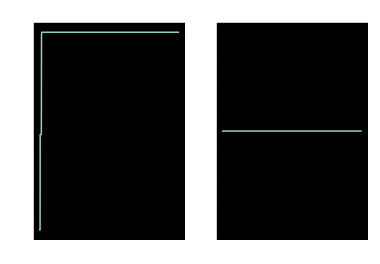

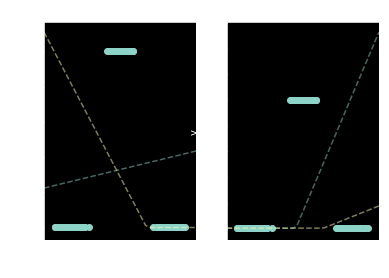

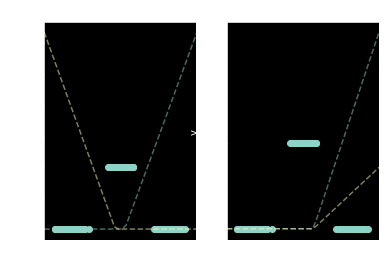

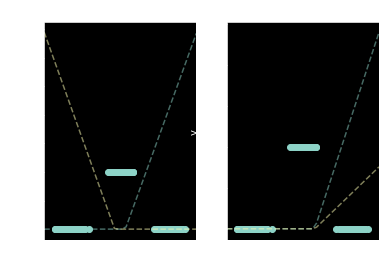

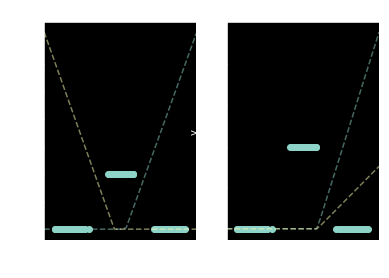

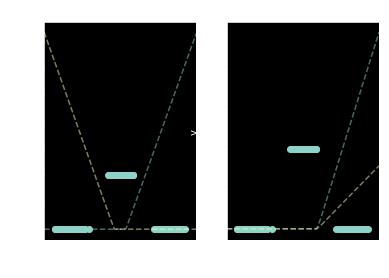

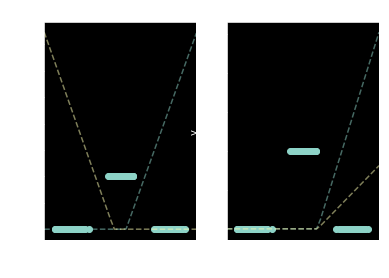

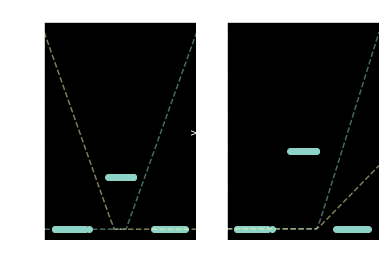

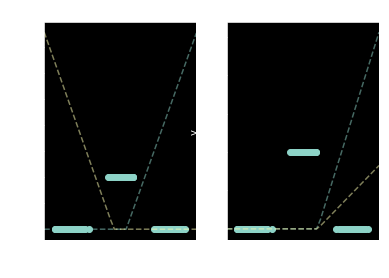

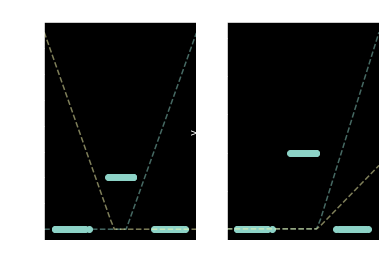

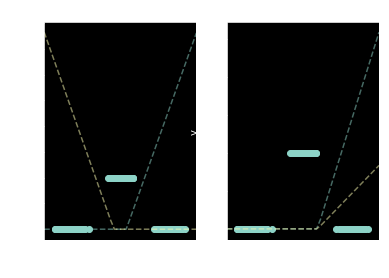

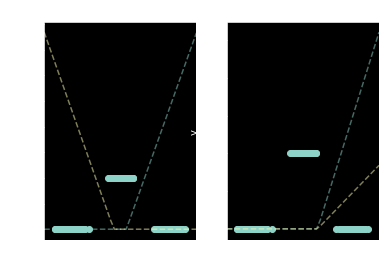

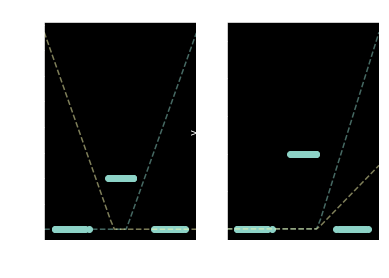

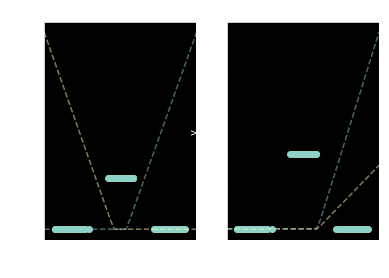

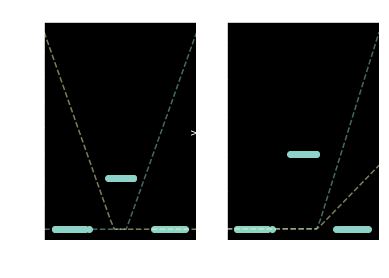

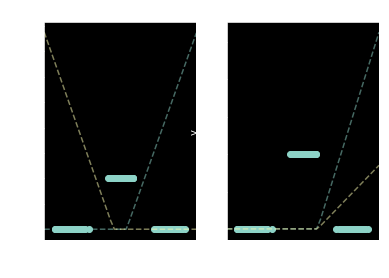

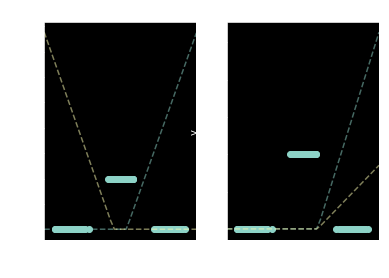

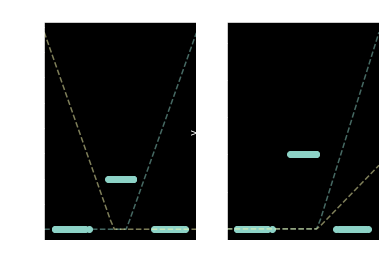

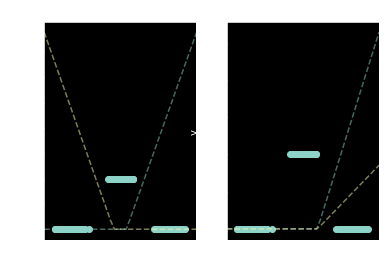

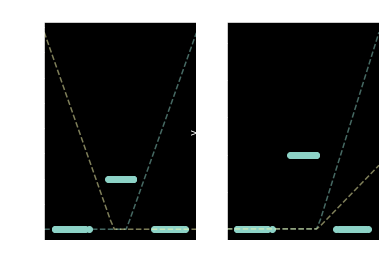

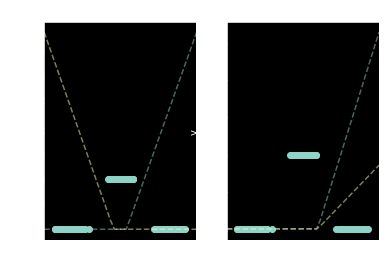

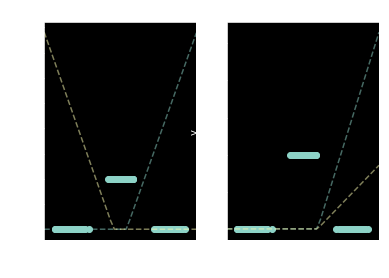

In [20]:
# select what to look at
num_hidden =  3
example_num = 0

results_default = results[results['init']=='default']
results_default = results_default[results_default['hidden1']==num_hidden]
results_data = results[results['init']=='data-driven']
results_data = results_data[results_data['hidden1']==num_hidden]

examples_default = sorted(results_default.weights.keys())
examples_data = sorted(results_data.weights.keys())
example_num_default = examples_default[example_num]
example_num_data = examples_data[example_num]   

# print(results_default.accs[example_num_default].keys())
# plot accuracies
plt.subplot(121)
plt.plot(results_default.accs[example_num_default])
plt.title('default acc')
plt.subplot(122)
plt.plot(results_data.accs[example_num_data])
plt.title('data acc')
plt.show()

def plot_relus(wt, bt, xs=np.linspace(-1.5, 1.5, 40)):
    for (w, b) in zip(wt, bt):
        ys = w * xs + b
        ys[ys < 0] = 0
        plt.plot(xs, ys, '--', alpha=0.5)
         

ts_default = list(sorted(results_default.weights[example_num_default].keys()))
ts_data = list(sorted(results_data.weights[example_num_data].keys()))
for i in range(len(ts_default)):

    bs0_default = np.array([results_default.weights[example_num_default][t]['0.bias'] for t in ts_default])
    ws0_default = np.array([results_default.weights[example_num_default][t]['0.weight'].flatten() for t in ts_default])
#     kinks_default = [-b/w for (b, w) in zip(bs0, ws0)]
    bs0_data = np.array([results_data.weights[example_num_data][t]['0.bias'] for t in ts_data])
    ws0_data = np.array([results_data.weights[example_num_data][t]['0.weight'].flatten() for t in ts_data])
#     kinks_default = [-b/w for (b, w) in zip(bs0, ws0)]


#     plt.figure(figsize=(8, 2))
    plt.subplot(121)
    viz.plot_data(X, y_scalar, show=False)
    plot_relus(ws0_default[i], bs0_default[i])
    plt.xlim((-1.5, 1.5))
    acc = results_default['accs'][example_num_default][i]
    plt.title('default (acc: {:.1f})'.format(acc))

    plt.subplot(122)
    viz.plot_data(X, y_scalar, show=False)
    plot_relus(ws0_data[i], bs0_data[i])
    plt.xlim((-1.5, 1.5))
    acc = results_data['accs'][example_num_data][i]
    plt.title('data (acc: {:.1f})'.format(acc))
    
    plt.show()